Не забудьте подключить ускоритель к блокноту.

---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>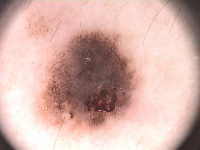</td><td>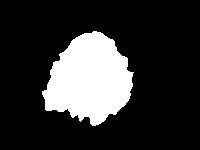</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2022-11-27 08:36:25--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2022-11-27 08:36:25--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc05772a8e14b3351f42aebd03df.dl.dropboxusercontent.com/cd/0/inline/BxhFYPpU4XL4xBiKvv7jkkKicVEwP6RQWX5t0S7NBMZTPeoX3b1lpLwXfV6fMR2SegUBTuMzRUccMKtVZ7xOa9m_cGC3QDZMKyru55nHkCt4avjlfr1wknJuQtZz1zBwORbfOLzSVdh2xjmk0BKlT2XRIy_OwPRyDNDB1uX-oocC5Q/file# [following]
--2022-11-27 08:36:25--  https://uc05772a8e14b3351f42aebd03df.dl.dropboxusercontent.com/cd/0/inline/BxhFYPpU4XL4xBiKvv7jkkKicVEwP6RQWX5t0S7NBMZTPeoX3b1lpLwXfV6fMR2SegUBTuM

In [ ]:
!ls

model.pt  PH2Dataset  PH2Dataset.rar  sample_data


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

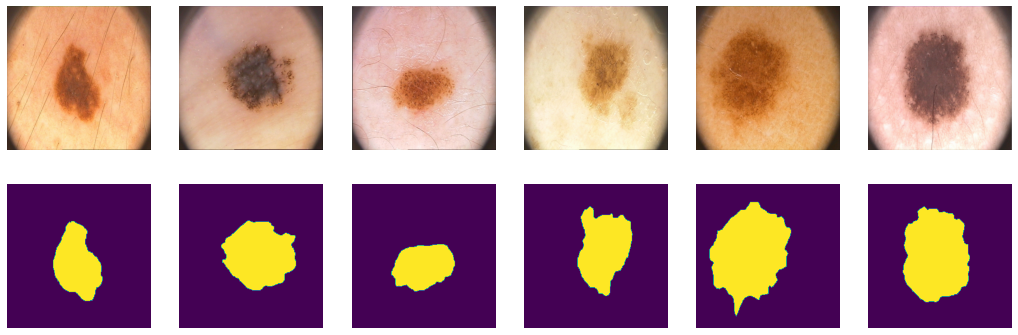

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

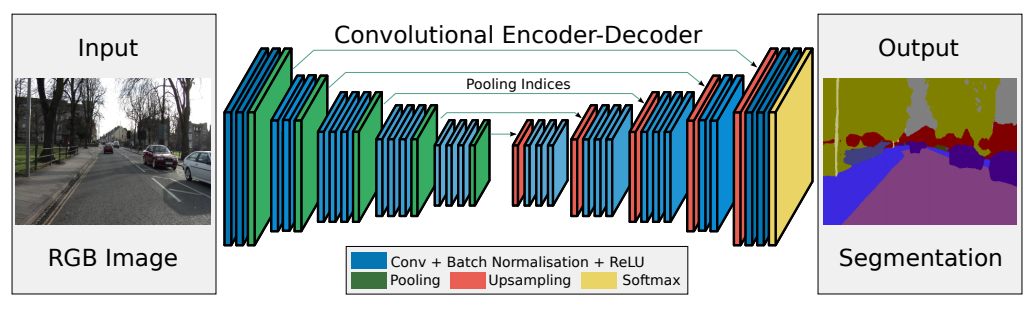

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

# Задание 1
Сверяясь с рисунком структуры сети сегнет реализуйте его блоки. (проход по сети уже реализован)

In [ ]:
class SegNet(nn.Module):

    def __init__(self):
        super(SegNet, self).__init__()


    def forward(self, x):
        # encoder
        x = self.enc_conv0(x) # 1 сверточный блок в энкодере
        x, ind1 = self.MaxEn(x) # Пулинг после 1 сверточного блока 
        size1 = x.size() # Узнаем размер выходного тензора после пулинга

        x = self.enc_conv1(x)
        x, ind2 = self.MaxEn(x)
        size2 = x.size()

        x = self.enc_conv2(x)  
        x, ind3 = self.MaxEn(x)
        size3 = x.size()

        x = self.enc_conv3(x) 
        x, ind4 = self.MaxEn(x)
        size4 = x.size()

        x = self.enc_conv4(x)
        x, ind5 = self.MaxEn(x)
        size5 = x.size()

        # decoder
        x = self.MaxDe(x, ind5, output_size=size4)
        x = self.dec_conv0(x)

        x = self.MaxDe(x, ind4, output_size=size3)
        x = self.dec_conv1(x)

        x = self.MaxDe(x, ind3, output_size=size2)
        x = self.dec_conv2(x)

        x = self.MaxDe(x, ind2, output_size=size1)
        x = self.dec_conv3(x)

        x = self.MaxDe(x, ind1)
        x = self.dec_conv4(x)

        return x

In [ ]:
from torchsummary import summary

summary(SegNet().cpu(), (3, 256, 256), device="cpu")

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

# Задание 2
Реализовать функцию BCE Loss.

Когда будете реализовать функции как логарифм используйте torch.log()

In [ ]:
def bce_loss(y_real, y_pred, reduction="mean"):
  y_pred = y_pred.float()
  y_real = y_real.float()

  bce = # здесь функция как на рисунке
  if reduction == "mean":
      return torch.mean(bce)
  elif reduction == "sum":
      return torch.sum(bce)

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    history = {"train_loss": [],
               "val_loss": [],
               "score": []}
    best_score = 0

    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            
            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        history["train_loss"].append(avg_loss.cpu().detach().numpy())

        # show intermediate results
        model.eval()  # testing mode

        Y_hat = model(X_val.to(device)).detach().cpu()
        history["val_loss"].append(loss_fn(Y_val, Y_hat).numpy())
        score = score_model(model, iou_pytorch, data_val)
        
        if score > best_score:
          best_score = score
          torch.save(model.state_dict(), "model.pt")

        history["score"].append(np.array(score))

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f, score: %f' % (epoch+1, epochs, avg_loss, score))
        plt.show()
    # load best model
    model.load_state_dict(torch.load("model.pt"))
    return history

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [model(X_batch.to(device)) for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data, threshold=0.5):
    model.to(device).eval() # testing mode
    scores = 0
    threshold = torch.tensor(threshold).to(device)
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        with torch.no_grad():
            Y_pred = model(X_batch)
        scores += metric((Y_pred > threshold), Y_label.to(device)).mean().item()
    return scores/len(data)

In [ ]:
def plot_history(history, title):
  fig, axs = plt.subplots(2)
  fig.suptitle(title)
  axs[0].plot(history["train_loss"], label="train loss", c="r")
  axs[0].plot(history["val_loss"], label="val loss", c="g")
  axs[1].plot(history["score"], label="score", c="b")
  fig.legend()

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet().to(device)

In [ ]:
max_epochs = 20
optim = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
history_segnet_bce = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch, data_ts)

In [ ]:
plot_history(history_segnet_bce, title="SegNet with BCELoss")

In [ ]:
del model

Ответьте себе на вопрос: не переобучается ли моя модель?

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred, smooth=1):
  y_pred = F.sigmoid(y_pred)       
  
  y_pred = y_pred.view(-1)
  y_real = y_real.view(-1)
  intersection = (y_pred * y_real).sum()                        
  dice = (2.*intersection + smooth) / (y_pred.sum() + y_real.sum() + smooth)  
  return 1 - dice

Проводим тестирование:

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 20
optimaizer = torch.optim.Adam(model_dice.parameters())
history_segnet_dice = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_ts)

0.6059999763965607

In [ ]:
plot_history(history_segnet_dice, title="SegNet with DiceLoss")

In [ ]:
del model_dice

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, alpha=1, gamma=2, smooth=1):
  y_pred = F.sigmoid(y_pred)       

  y_pred = y_pred.view(-1)
  y_real = y_real.view(-1)

  BCE = F.binary_cross_entropy(y_pred, y_real, reduction='mean')
  BCE_EXP = torch.exp(-BCE)
  focal_loss = alpha * (1-BCE_EXP)**gamma * BCE

  return focal_loss

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 20
optimaizer = torch.optim.Adam(model_focal.parameters())
history_segnet_focal = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_focal, iou_pytorch, data_ts)

In [ ]:
plot_history(history_segnet_focal, title="SegNet with FocalLoss")

In [ ]:
del model_focal

In [ ]:
def tversky_loss(y_real, y_pred, alpha=1, beta=0.5):
  y_pred = torch.sigmoid(y_pred)
  pp = (y_real * y_pred).sum()
  den1 = alpha * ((1 - y_real) * y_pred).sum()
  den2 = beta * (y_real * (1 - y_pred)).sum()
  tl = 1 - (1 + pp) / (1 + pp + den1 + den2)
  return tl

In [ ]:
model_tversky = SegNet().to(device)

max_epochs = 20
optim = torch.optim.Adam(model_tversky.parameters(), lr=1e-4, weight_decay=1e-4)
history_segnet_tversky = train(model_tversky, optim, tversky_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_tversky, iou_pytorch, data_ts)

In [ ]:
plot_history(history_segnet_tversky, title="SegNet with TverskyLoss")

In [ ]:
del model_tversky

In [ ]:
def combo_loss(y_real, y_pred, alpha=0.5, beta=0.5):
  return alpha * tversky_loss(y_real, y_pred) + beta * dice_loss(y_real, y_pred)

In [ ]:
model_combo = SegNet().to(device)

max_epochs = 20
optim = torch.optim.Adam(model_combo.parameters(), lr=1e-4, weight_decay=1e-4)
history_segnet_combo = train(model_combo, optim, combo_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_combo, iou_pytorch, data_ts)

In [ ]:
plot_history(history_segnet_combo, title="SegNet with ComboLoss")

In [ ]:
del model_combo

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

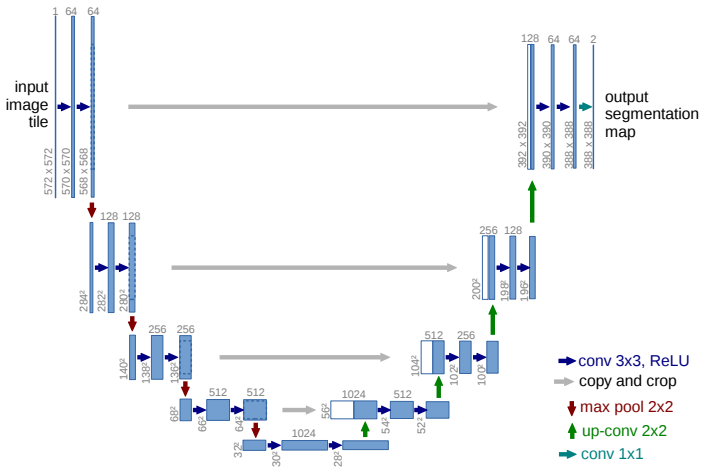

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

# Задание 3
Реализуйте модель UNet. Подсказка: возьмите модель сегнета как за основу (ничего в структуре модели не меняется) и реализуйте проход по сети.

Соединение карт признаков происходит при помощи функции: torch.cat((feature_maps_1, feature_maps_2), dim=1)

In [ ]:
class UNet(nn.Module):

    def __init__(self):
        super(UNet, self).__init__()


    def forward(self, x):
        # encoder

        # decoder

        return x

In [ ]:
summary(UNet().cpu(), (3, 256, 256), device="cpu")

In [ ]:
unet_model_bce = UNet().to(device)

In [ ]:
history_unet_bce = train(unet_model_bce, torch.optim.Adam(unet_model_bce.parameters(), lr=1e-4, weight_decay=1e-4), bce_loss, 20, data_tr, data_val)

In [ ]:
score_model(unet_model_bce, iou_pytorch, data_ts)

In [ ]:
plot_history(history_unet_bce, title="UNet with BCELoss")

In [ ]:
del unet_model_bce

# Задание 4: 
Напишите отчет о проделанной работе. Опишите каждую модель, функцию активации, интерпретируйте кривые обучения. По этому отчёту будут выставлятся итоговая оценка за практическую, поэтому приветсвуется креативность.